### Unit 08: Final Energy Demands
## Welcome to your 8-Region-Renewable-Energy System Model of Niger

#### Solution exercise 1 - Adding and changing electricity demands 2030

#### 1. Import FINE and further modules to run the model 

In [11]:
import FINE as fn
import geopandas as gpd
import pandas as pd
import numpy as np
import geokit as gk
from os.path import dirname, abspath, join
import matplotlib.pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 2. Set paths as input data for the model 

In [12]:
#set paths
cwd = os.getcwd()
data_dir = join(cwd, "data")

path_to_regions = join(data_dir, "regions", "region_shape_NER.shp")

path_to_pv_ts = join(data_dir, "sources", "solar_ts_NER.csv")
path_to_onshore_ts = join(data_dir, "sources", "onshore_ts_NER.csv")

path_to_pv_cap = join(data_dir, "sources", "solar_cap_NER.csv")
path_to_onshore_cap = join(data_dir, "sources", "onshore_cap_NER.csv")

path_to_el_dem = join(data_dir, "sinks", "electricity_dem2030_NER.xlsx")
path_to_h2_dem = join(data_dir, "sinks", "hydrogen_dem_NER.xlsx")

#### Hint: Where is the "data" folder? 

In [13]:
## Show path to data folder
data_dir

'c:\\Programming\\GradSchool2022\\wascal_graduate_school\\student_files\\exercises\\Unit_08_ElectricityAndHydrogenDemand\\data'

#### 2.1 Set up the regions and the commodities of the model

In [14]:
locations_shape = gpd.read_file(path_to_regions)
locations = locations_shape.GID_1.to_list() #will be ["NER.1_1", "NER.2_1", ... "NER.8_1"]

commodities = {"electricity", "hydrogen_gas"}
commodityUnitsDict = {
                "electricity": r"GW$_{el}$",
                "hydrogen_gas": r"GW$_{H_{2},LHV}$",
            }
            

#### 3 Set up the energy system model class

In [15]:
#Set up esm Model

esM = fn.EnergySystemModel(
    locations=set(locations),
    commodities=commodities,
    numberOfTimeSteps=8760, #hours per year
    commodityUnitsDict=commodityUnitsDict,
    hoursPerTimeStep=1, #time step is one hour
    costUnit="1e9 Euro",
    lengthUnit="km",
    verboseLogLevel=0, #what is printed, just keep it
)


#### 4 Add the electricity "sources" to the model

Wind Onshore

In [16]:
# to add pv, the maximum capacity and the time series of each region must first be loaded as input data
pv_time_series=pd.read_csv(path_to_pv_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
pv_capacity_max=pd.read_csv(path_to_pv_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]
# add PV
esM.add(
    fn.Source(
        esM=esM, 
        name="PV", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=pv_time_series,
        capacityMax=pv_capacity_max,
        investPerCapacity=0.45, #1e9EUR/GW, 2030
        opexPerCapacity=0.017*0.45, #1e9EUR/a
        interestRate=0.08,  #1
        economicLifetime=20, #a
        ),
)


Solar PV

In [17]:
# to add wind, the maximum capacity and the time series of each region must first be loaded as input data
onshore_time_series=pd.read_csv(path_to_onshore_ts, index_col=[0]).reset_index(drop=True) #capacity factor [1]
onshore_capacity_max=pd.read_csv(path_to_onshore_cap, index_col=[0])['capacity_kW'] / 1e6 #capacity [GW]
#add Wind Onshore
esM.add(
    fn.Source(
        esM=esM, 
        name="Onshore", 
        commodity="electricity", 
        hasCapacityVariable=True,
        operationRateMax=onshore_time_series,
        capacityMax=onshore_capacity_max,
        investPerCapacity=1.13, #1e9EUR/GW, 2030
        opexPerCapacity=0.025*1.13, #1e9EUR/a
        interestRate=0.08, #1
        economicLifetime=20, #years
        ),
)

4.1 Add super expensive power source, so that the electricity demand also can be compensated when the sun is not shining and the wind is not blowing. If you would not add this, the model would not be solveable! 

In [18]:
# Add SuperExpensiveElectricity
esM.add(
    fn.Source(
        esM=esM, 
        name="SuperExpensiveElectricity", 
        commodity="electricity", 
        hasCapacityVariable=True,
        investPerCapacity=10e10, 
        opexPerCapacity=10e10,
        opexPerOperation=10e10, 
        interestRate=0.08, 
        economicLifetime=20, #years
        ),
)

#### 6 Add the Demand

Electricity Demand

In [19]:
#add electricity Demands
electricity_demand_operationRateFix=pd.read_excel(path_to_el_dem, index_col=[0], engine="openpyxl")*3 #elec demand GW

esM.add(
    fn.Sink(
        esM=esM, 
        name="electricity_demand", 
        commodity="electricity",
        hasCapacityVariable=False, 
        operationRateFix=electricity_demand_operationRateFix, #GW
    ),
)

# Hint
print(f"Here you can find the electricity demands: {path_to_el_dem}") 

Here you can find the electricity demands: c:\Programming\GradSchool2022\wascal_graduate_school\student_files\exercises\Unit_08_ElectricityAndHydrogenDemand\data\sinks\electricity_dem2030_NER.xlsx


#### 7 Right now you have 8760 time steps. Aggregation to 7 typical time periods with the "aggregateTemporally" method

In [20]:
# use time aggregation tool to reduce the calculation time to 7 typical time periods
esM.aggregateTemporally(numberOfTypicalPeriods=7, segmentation=True)


Clustering time series data with 7 typical periods and 24 time steps per period 
further clustered to 24 segments per period...
		(0.2849 sec)



 c:\Users\a.burdack\Anaconda3\envs\GradSchoolESM\lib\site-packages\tsam\timeseriesaggregation.py:1070: UserWarning:Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series


#### 8 Start the optimization

In [21]:
#Optimize the model:
print('Optimize')
esM.optimize(
    timeSeriesAggregation=True,
    optimizationSpecs="",
    solver="glpk"
)
print('Optimization done!')

Optimize
Time series aggregation specifications:
Number of typical periods:7, number of time steps per period:24, number of segments per period:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3279 sec)

Declaring shared potential constraint...
		(0.0000 sec)

Declaring linked component quantity constraint...
		(0.0000 sec)

Declaring commodity balances...
		(0.0269 sec)

		(0.0000 sec)

Declaring objective function...
		(0.0538 sec)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmpfu2f0f7_.glpk.raw --wglp
 C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmp6extdub0.glpk.glp --cpxlp C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmp0klw1w9w.pyomo.lp
Reading problem data from 'C:\Users\A0C9B~1.BUR\AppData\Local\Temp\tmp0klw1w9w.pyomo.lp'...
6745 rows, 5425 columns, 13611 non-zeros
40646 lines were read
Writing problem data to 'C:\U

### Results:

In [22]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

NER.1_1  \
Component                 Property  Unit                                     
Onshore                   TAC       [1e9 Euro/a]                       0.0   
                          capacity  [GW$_{el}$]                        0.0   
                          capexCap  [1e9 Euro/a]                       0.0   
                          invest    [1e9 Euro]                         0.0   
                          operation [GW$_{el}$*h/a]                    0.0   
                                    [GW$_{el}$*h]                      0.0   
                          opexCap   [1e9 Euro/a]                       0.0   
PV                        TAC       [1e9 Euro/a]                  53.77403   
                          capacity  [GW$_{el}$]                1005.432254   
                          capexCap  [1e9 Euro/a]                 46.082473   
                          invest    [1e9 Euro]                  452.444514   
                          operation [GW$_{el}$*h/a]             452.961884   
                                    [GW$_{el}$*h]               452.961884   
                          opexCap   [1e9 Euro/a]                  7.691557   
SuperExpensiveElectricity TAC       [1e9 Euro/a]      39001004043301.40625   
                          capacity  [GW$_{el}$]                   0.194027   
                          capexCap  [1e9 Euro/a]         1976212203.777437   
                          invest    [1e9 Euro]          19402742725.087101   
                          operation [GW$_{el}$*h/a]             389.796251   
                                    [GW$_{el}$*h]               389.796251   
                          opexCap   [1e9 Euro/a]        19402742725.087101   
                          opexOp    [1e9 Euro/a]     38979625088372.539062   
electricity_demand        operation [GW$_{el}$*h/a]             842.758135   
                                    [GW$_{el}$*h]               842.758135   

                                                                   NER.2_1  \
Component                 Property  Unit                                     
Onshore                   TAC       [1e9 Euro/a]                       0.0   
                          capacity  [GW$_{el}$]                        0.0   
                          capexCap  [1e9 Euro/a]                       0.0   
                          invest    [1e9 Euro]                         0.0   
                          operation [GW$_{el}$*h/a]                    0.0   
                                    [GW$_{el}$*h]                      0.0   
                          opexCap   [1e9 Euro/a]                       0.0   
PV                        TAC       [1e9 Euro/a]                  6.863512   
                          capacity  [GW$_{el}$]                 128.329541   
                          capexCap  [1e9 Euro/a]                  5.881791   
                          invest    [1e9 Euro]                   57.748293   
                          operation [GW$_{el}$*h/a]             604.125771   
                                    [GW$_{el}$*h]               604.125771   
                          opexCap   [1e9 Euro/a]                  0.981721   
SuperExpensiveElectricity TAC       [1e9 Euro/a]     52016543718737.554688   
                          capacity  [GW$_{el}$]                   0.258779   
                          capexCap  [1e9 Euro/a]         2635720054.313601   
                          invest    [1e9 Euro]          25877888018.021198   
                          operation [GW$_{el}$*h/a]             519.880301   
                                    [GW$_{el}$*h]               519.880301   
                          opexCap   [1e9 Euro/a]        25877888018.021198   
                          opexOp    [1e9 Euro/a]      51988030110665.21875   
electricity_demand        operation [GW$_{el}$*h/a]            1124.006072   
                                    [GW$_{el}$*h]              1124.006072   

         

## Plots

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

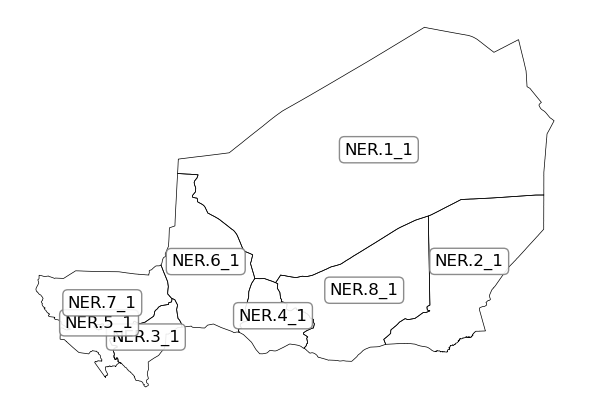

In [23]:
## Show GID_1 Regions in Niger
fn.plotLocations(path_to_regions, plotLocNames=True, indexColumn="GID_1")

#### 1) Wind Onshore installed capacity

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

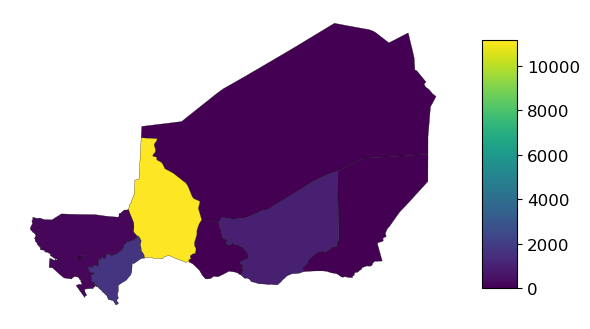

In [24]:
fn.plotLocationalColorMap(
    esM, "Onshore", path_to_regions, "GID_1", perArea=False
)

#### 2. PV installed capacity

(<Figure size 600x600 with 2 Axes>, <AxesSubplot:>)

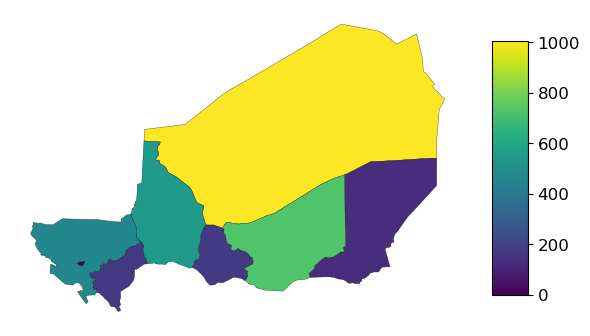

In [25]:
fn.plotLocationalColorMap(
    esM, "PV", path_to_regions, "GID_1", perArea=False
)